# OOD Detection for Customer Intent Classification


## Setup

### Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm

from typing import (
    List, 
    Dict, 
    Optional, 
    Tuple
) 
from enum import Enum

from rich import print

from itertools import chain

import matplotlib.pyplot as plt 
from matplotlib.axes import Axes
import seaborn as sns

import pickle as pkl 
import json

In [3]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    roc_curve, 
    precision_recall_curve, 
    auc, 
    balanced_accuracy_score, 
    classification_report
) 

from sklearn.linear_model import LogisticRegression 

from sklearn.ensemble import RandomForestClassifier

In [4]:
from transformers import AutoConfig

import torch 
from torch import Tensor

In [5]:
from Todd import (
    ScorerType, 
    MahalanobisScorer, 
    CosineProjectionScorer, 
    DataDepthScorer, 
)

In [6]:
from toddbenchmark.classification_datasets import (
    prep_model, 
    load_b77, 
)
from toddbenchmark.classification_datasets_configs import (
    DATASETS_CONFIGS,
    load_requested_dataset,
)

from toddbenchmark.utils_classification import (
    prepare_detectors,
    evaluate_dataloader,
)

### Helper Functions

In [54]:
SCORERS = [
    "MahalanobisScorerLast", 
    "MahalanobisScorerAvg", 
    "CosineProjectionScorerLast", 
    "CosineProjectionScorerAvg", 
    "msp", 
    "energy"
]

HD_SCORERS = [
    "MahalanobisScorer", 
    "MahalanobisScorer", 
    "CosineProjectionScorer",
]

COLORS_SCORERS = {
    scorer: col 
    for scorer, col in zip(SCORERS, sns.color_palette(n_colors=len(SCORERS))) 
}


DS = [
    "in_train",
    "out_test",
    "out_atis", 
    "out_bitext", 
    "out_clinc"
]

COLORS_DS = {
    ds: col 
    for ds, col in zip(DS, sns.color_palette(n_colors=len(DS))) 
}

class Model(Enum): 
    BERT = "philschmid/BERT-Banking77"
    DistilBERT = "philschmid/DistilBERT-Banking77"

class HiddenLayers(Enum):
    BERT = 13 
    DistilBERT = 6

class LayerSelection(Enum): 
    LAST = [-1]

    ALL_BERT = [l for l in range(HiddenLayers.BERT.value)]
    ALL_DistilBERT = [l for l in range(HiddenLayers.DistilBERT.value)]

    ENCODER_BERT = [l for l in range(1, HiddenLayers.BERT.value)]
    ENCODER_DistilBERT = [l for l in range(1, HiddenLayers.DistilBERT.value)]

def average_scorer_per_layer(records: Dict, scorer_name: str) -> np.ndarray:
    """Description. Average scorer values across multiple layers."""

    if scorer_name not in HD_SCORERS:
        raise ValueError(f"scorer_name must be in {HD_SCORERS}")

    values_per_layer = [
        values 
        for key, values in records.items()
        if scorer_name in key and "-1" not in key
    ]

    return np.mean(values_per_layer, axis=0)

def get_scorer_per_layer(records: Dict, scorer_name: str, layer: int) -> List: 
    """Description. Return scorer values for one layer."""

    if scorer_name not in HD_SCORERS:
        raise ValueError(f"scorer_name must be in {HD_SCORERS}")

    pattern = "+"
    if scorer_name == "MahalanobisScorer":
        pattern += "layer_"

    values = [
        values 
        for key, values in records.items()
        if scorer_name in key and f"{pattern}{layer}_" in key
    ]

    return values[0]

def plot_scorer_distrib(
    scorer: str, 
    records: List, 
    ds_names: List, 
    ax: Axes, 
    density: bool
  ): 
    """Description. Return histogram/density plot for scorer values.
    
    Details: if scorer is CosineProjectionScorer, only test in-ds and out-ds are plotted."""

    for ds in ds_names: 
        if ds not in DS: 
          raise ValueError(f"{ds} not in {DS}.")

    tmp = pd.DataFrame\
        .from_dict(records, orient="index")\
        .transpose()[ds_names]
    title = scorer

    if "CosineProjectionScorer" in scorer and "in_train" in tmp.columns:
        tmp = tmp.drop(labels=["in_train"], axis=1)
        title += "\nWithout training IN-DS (reference)"

    args = {
        "bins": 100, 
        "palette": [color for ds, color in COLORS_DS.items() if ds in tmp.columns]
    }   

    if density: 
        args["stat"] = "density"
        args["kde"] = True

    sns.histplot(data=tmp, ax=ax, **args)

    ax.set_title(title) 

def load_records(model: Model, dataset: str) -> Dict:
    """Description. Load records from backup/folder.""" 

    file_path = f"./backup/{model.name}_records_{dataset}.pkl"
    with open(file_path, "rb") as file: 
        records = pkl.load(file)

    return records

def save_records(records: Dict, model: Model, dataset: str): 

    file_path = f"./backup/{model.name}_records_{dataset}.pkl"
    with open(file_path, "wb") as file: 
        pkl.dump(records, file)
        print(f"File successfully saved at {file_path}.")

### Load config, model and tokenizer

In [17]:
config = AutoConfig.from_pretrained(Model.BERT.value) 
config

BertConfig {
  "_name_or_path": "philschmid/BERT-Banking77",
  "_num_labels": 77,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Refund_not_showing_up",
    "1": "activate_my_card",
    "2": "age_limit",
    "3": "apple_pay_or_google_pay",
    "4": "atm_support",
    "5": "automatic_top_up",
    "6": "balance_not_updated_after_bank_transfer",
    "7": "balance_not_updated_after_cheque_or_cash_deposit",
    "8": "beneficiary_not_allowed",
    "9": "cancel_transfer",
    "10": "card_about_to_expire",
    "11": "card_acceptance",
    "12": "card_arrival",
    "13": "card_delivery_estimate",
    "14": "card_linking",
    "15": "card_not_working",
    "16": "card_payment_fee_charged",
    "17": "card_payment_not_recognised",
    "18": "card_payment_wrong_exchange_rate",
   

In [11]:
LABEL_MAPPING = config.id2label
LABEL_MAPPING

{0: 'Refund_not_showing_up',
 1: 'activate_my_card',
 2: 'age_limit',
 3: 'apple_pay_or_google_pay',
 4: 'atm_support',
 5: 'automatic_top_up',
 6: 'balance_not_updated_after_bank_transfer',
 7: 'balance_not_updated_after_cheque_or_cash_deposit',
 8: 'beneficiary_not_allowed',
 9: 'cancel_transfer',
 10: 'card_about_to_expire',
 11: 'card_acceptance',
 12: 'card_arrival',
 13: 'card_delivery_estimate',
 14: 'card_linking',
 15: 'card_not_working',
 16: 'card_payment_fee_charged',
 17: 'card_payment_not_recognised',
 18: 'card_payment_wrong_exchange_rate',
 19: 'card_swallowed',
 20: 'cash_withdrawal_charge',
 21: 'cash_withdrawal_not_recognised',
 22: 'change_pin',
 23: 'compromised_card',
 24: 'contactless_not_working',
 25: 'country_support',
 26: 'declined_card_payment',
 27: 'declined_cash_withdrawal',
 28: 'declined_transfer',
 29: 'direct_debit_payment_not_recognised',
 30: 'disposable_card_limits',
 31: 'edit_personal_details',
 32: 'exchange_charge',
 33: 'exchange_rate',
 34: 

In [18]:
model, tokenizer = prep_model(Model.BERT.value, config={"label": config._num_labels})

In [13]:
model 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Datasets

An instance is considered in-distribution (IN-DS) if it belongs to the dataset which has been used to train the classifier. In this context, all instances in `b77` training set are labelled `OOD=0`. In the opposite, instances in `b77` test set, `CLINC150`, `ATIS` and `Bitext` are out-of-distribution (OUT-DS) and labelled `OOD=1`. 

### `banking77`

In [20]:
config_args_b77 = {
    "tokenizer": tokenizer, 
    "train_size": 3000, 
    "validation_size": 0, 
    "test_size": 3000, 
    "ood_label": 0
}

In [15]:
train_loader_b77, _, test_loader_b77 = load_requested_dataset(config_name="b77", **config_args_b77)

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

Dataset banking77 downloaded and prepared to /root/.cache/huggingface/datasets/banking77/default/1.1.0/ff44c4421d7e70aa810b0fa79d36908a38b87aff8125d002cd44f7fcd31f493c. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Aligning the labels:   0%|          | 0/10003 [00:00<?, ? examples/s]

Aligning the labels:   0%|          | 0/3080 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
for batch in train_loader_b77: 
    break 

batch

{'text': ['I am still waiting on my card?',
  "What can I do if my card still hasn't arrived after 2 weeks?",
  'I have been waiting over a week. Is the card still coming?',
  'Can I track my card while it is in the process of delivery?',
  'How do I know if I will get my card, or if it is lost?',
  'When did you send me my new card?',
  'Do you have info about the card on delivery?',
  'What do I do if I still have not received my new card?',
  'Does the package with my card have tracking?',
  "I ordered my card but it still isn't here",
  'Why has my new card still not come?',
  "I still haven't received my card after two weeks, is it lost?",
  'Can you track my card for me?',
  'Is there a way to track the delivery of my card?',
  "It's been a week since I ordered my card and it's not here. Please help?",
  'Will I be able to track the card that was sent to me?'],
 'labels': tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]),
 'ood': tensor([0, 0, 0, 0, 0, 0, 0

In [137]:
assert sum(batch["labels"].shape[0] for batch in train_loader_b77) == config_args_b77["train_size"]
assert sum(batch["labels"].shape[0] for batch in test_loader_b77) == config_args_b77["test_size"]

### Other datasets

In [21]:
config_args_out = {
    "tokenizer": tokenizer, 
    "train_size": 0, 
    "validation_size": 0, 
    "test_size": 3000, 
    "ood_label": 1, 
    "data_path": "./datasets/"
}

In [52]:
_, _, test_loader_atis = load_requested_dataset(config_name="atis", **config_args_out)
_, _, test_loader_bitext = load_requested_dataset(config_name="bitext", **config_args_out)
_, _, test_loader_clinc = load_requested_dataset(config_name="clinc150", **config_args_out)

In [142]:
for batch in test_loader_atis: 
    break

batch

{'text': ['i want to fly from boston at 838 am and arrive in denver at 1110 in the morning',
  'what flights are available from pittsburgh to baltimore on thursday morning',
  'what is the arrival time in san francisco for the 755 am flight leaving washington',
  'cheapest airfare from tacoma to orlando',
  'round trip fares from pittsburgh to philadelphia under 1000 dollars',
  'i need a flight tomorrow from columbus to minneapolis',
  'what kind of aircraft is used on a flight from cleveland to dallas',
  'show me the flights from pittsburgh to los angeles on thursday',
  'all flights from boston to washington',
  'what kind of ground transportation is available in denver',
  'show me the flights from dallas to san francisco',
  'show me the flights from san diego to newark by way of houston',
  "what's the airport at orlando",
  'what is the cheapest flight from boston to bwi',
  'all flights to baltimore after 6 pm',
  'show me the first class fares from boston to denver'],
 'label

In [ ]:
for batch in test_loader_bitext: 
    break

batch

{'text': ['how can I cancel purchase 113542617735902?',
  'can you help me canceling purchase 00004587345?',
  'i want assistance to cancel purchase 732201349959',
  'i want assistance to cancel order 732201349959',
  "I don't want my last item, help me cancel order 370795561790",
  'I can no longer pay for purchase 00004587345',
  'I need assistance cancelling purchase 732201349959',
  'is it possible to cancel order 113542617735902?',
  'assistance cancelling purchase 00123842',
  'i can no longer pay for purchase 113542617735902',
  'how tocancel purchase 00004587345',
  'i need assistance cancelling order 00123842',
  'problems with cancelling purchase 00123842',
  'need to cancel order 00004587345',
  'I have got to cancel purchase 732201349959',
  "I can't afford this order, cancel purchase 732201349959"],
 'labels': ['cancel_order',
  'cancel_order',
  'cancel_order',
  'cancel_order',
  'cancel_order',
  'cancel_order',
  'cancel_order',
  'cancel_order',
  'cancel_order',
  'c

In [53]:
for batch in test_loader_clinc: 
    break

batch

{'text': ['transfer ten dollars from my wells fargo account to my bank of america account',
  'take one hundred and fifty bucks from my wells fargo checking account and put it in my wells fargo savings account',
  'put one hundred and seventy five bucks in my wells fargo checking account from my citibank savings account',
  'move two hundred dollars to my chase savings account to my wells fargo checking account',
  'move three hundred and fifty dollars from my citibank savings account to my chase savings account',
  'move a dollar from my checkings to my savings',
  'move my money to the other account',
  'transfer funds to the other account',
  'please transfer half of my funds to an alternate account',
  'can you move my money to my savings',
  'make an eft to my savings from my checking account',
  'send 100 dollars from my vanguard money market to my wells fargo savings',
  'i need 200 dollars transferred from my long island savings account to my chase checking',
  'send from my bb

## Detectors

### Fit

In [83]:
detectors: List[ScorerType] = [
    MahalanobisScorer(layers=LayerSelection.LAST.value), 
    CosineProjectionScorer(layers=LayerSelection.LAST.value), 
    MahalanobisScorer(layers=LayerSelection.ENCODER_BERT.value), 
    CosineProjectionScorer(layers=LayerSelection.ALL_BERT.value)
]

In [84]:
for detector in detectors: 
    print(detector.__class__.__name__, detector.__dict__) 

MahalanobisScorer
{
    'score_names': [],
    'chosen_state': 'encoder_hidden_states',
    'use_first_token_only': True,
    'accumulated_embeddings': defaultdict(<class 'list'>, {}),
    'layers': {-1},
    'accumulation_device': 'cpu',
    'covs': None,
    'means': None
}

CosineProjectionScorer
{
    'score_names': [],
    'chosen_state': 'encoder_hidden_states',
    'use_first_token_only': True,
    'accumulated_embeddings': defaultdict(<class 'list'>, {}),
    'layers': {-1},
    'accumulation_device': 'cpu',
    'reference_embeddings': {}
}

MahalanobisScorer
{
    'score_names': [],
    'chosen_state': 'encoder_hidden_states',
    'use_first_token_only': True,
    'accumulated_embeddings': defaultdict(<class 'list'>, {}),
    'layers': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},
    'accumulation_device': 'cpu',
    'covs': None,
    'means': None
}

CosineProjectionScorer
{
    'score_names': [],
    'chosen_state': 'encoder_hidden_states',
    'use_first_token_only': True,
    'accumulated_embeddings': defaultdict(<class 'list'>, {}),
    'layers': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},
    'accumulation_device': 'cpu',
    'reference_embeddings': {}
}

In [85]:
detectors = prepare_detectors(detectors, model, train_loader_b77, tokenizer)

  warnings.warn(_create_warning_msg(
Fitting detectors...: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


In [86]:
# file_path = f"./backup/DistilBERT_detectors.pkl"
file_path = f"./backup/BERT_detectors.pkl"

with open(file_path, "wb") as f: 
    pkl.dump(detectors, f)

### Evaluate

In [20]:
# file_path = f"./backup/DistilBERT_detectors.pkl"
file_path = f"./backup/BERT_detectors.pkl"

with open(file_path, "rb") as f: 
    detectors = pkl.load(f)

#### IN

In [126]:
print("Evaluating on the IN-DS b77 training set")

records_in_train = evaluate_dataloader(
    model,
    train_loader_b77,
    tokenizer,
    detectors
)

save_records(records_in_train, Model.BERT, "in_train")

Evaluating on the IN-DS b77 training set

#### OUT

In [127]:
print("Evaluating on the OUT-DS b77 test set")

records_in_test = evaluate_dataloader(
    model,
    test_loader_b77,
    tokenizer,
    detectors
)

save_records(records_in_test, Model.BERT, "in_test")

Evaluating on the OUT-DS b77 test set

In [128]:
print("Evaluating on the OUT-DS ATIS dataset")

records_out_atis = evaluate_dataloader(
    model,
    test_loader_atis,
    tokenizer,
    detectors
)

save_records(records_out_atis, Model.BERT, "out_atis")

Evaluating on the OUT-DS ATIS dataset

In [129]:
print("Evaluating on the OUT-DS BITEXT dataset")

records_out_bitext = evaluate_dataloader(
    model,
    test_loader_bitext,
    tokenizer,
    detectors
)

save_records(records_out_bitext, Model.BERT, "out_bitext")

Evaluating on the OUT-DS BITEXT dataset

In [26]:
print("Evaluating on the OUT-DS CLINC150 dataset")

records_out_clinc = evaluate_dataloader(
    model,
    test_loader_clinc,
    tokenizer,
    detectors
)

save_records(records_out_clinc, Model.BERT, "out_clinc")

Evaluating on the out-distribution CLINC150 dataset

Evaluating detectors...: 100%|██████████| 188/188 [14:41<00:00,  4.69s/it]


File successfully saved at ./backup/BERT_records_out_clinc.pkl.

## Results

### Load records

In [278]:
records = {
    model.name: {
      dataset: load_records(model, dataset)
      for dataset in (
        "in_train", 
        "out_test", 
        "out_atis", 
        "out_bitext", 
        "out_clinc"
      )
    }
    for model in (Model.BERT, Model.DistilBERT)
}

In [279]:
for model, model_records in records.items(): 

    for dataset, records_ in model_records.items(): 
        # average CosineProjectionScorer over all hidden layers
        records[model][dataset]["CosineProjectionScorerAvg"] = average_scorer_per_layer(records_, "CosineProjectionScorer")

        # average MahalanobisScorer over all hidden layers
        records[model][dataset]["MahalanobisScorerAvg"] = average_scorer_per_layer(records_, "MahalanobisScorer")

        # get scorers for last hidden state 
        records[model][dataset]["MahalanobisScorerLast"] = get_scorer_per_layer(records_, "MahalanobisScorer", -1)
        records[model][dataset]["CosineProjectionScorerLast"] = get_scorer_per_layer(records_, "CosineProjectionScorer", -1)

+layer_

IndexError: list index out of range

In [275]:
list(records[model][dataset].keys())

['MahalanobisScorer(layers={-1},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_-1_class_0',
 'CosineProjectionScorer(layers={-1},use_first_token_only=True,chosen_state=encoder_hidden_states)+-1_0',
 'MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_1_class_0',
 'MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_2_class_0',
 'MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_3_class_0',
 'MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_4_class_0',
 'MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_5_class_0',
 'MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 

### Scorer distribution

#### All datasets

In [121]:
all_scores = {
    model: {
      
      scorer: {
          dataset: records_[dataset][scorer]
          for dataset in records_.keys()
      }

      for scorer in SCORERS
      
    }
    for model, records_ in records.items()
}

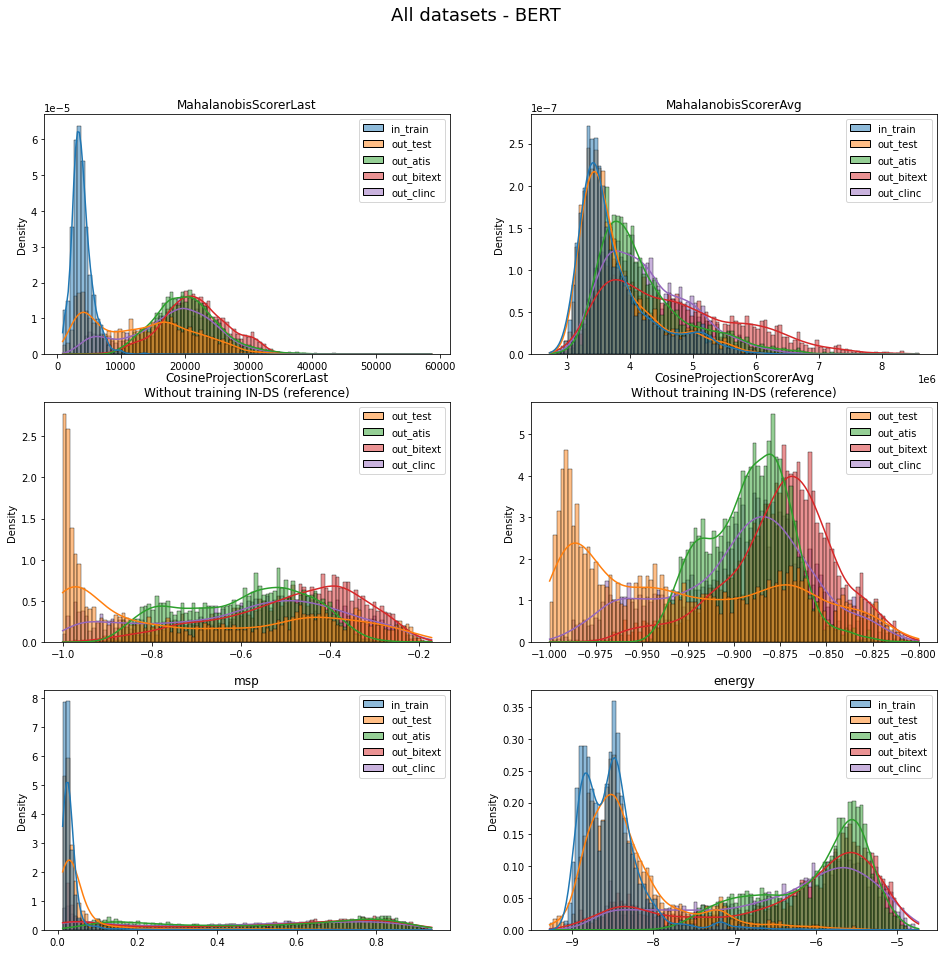

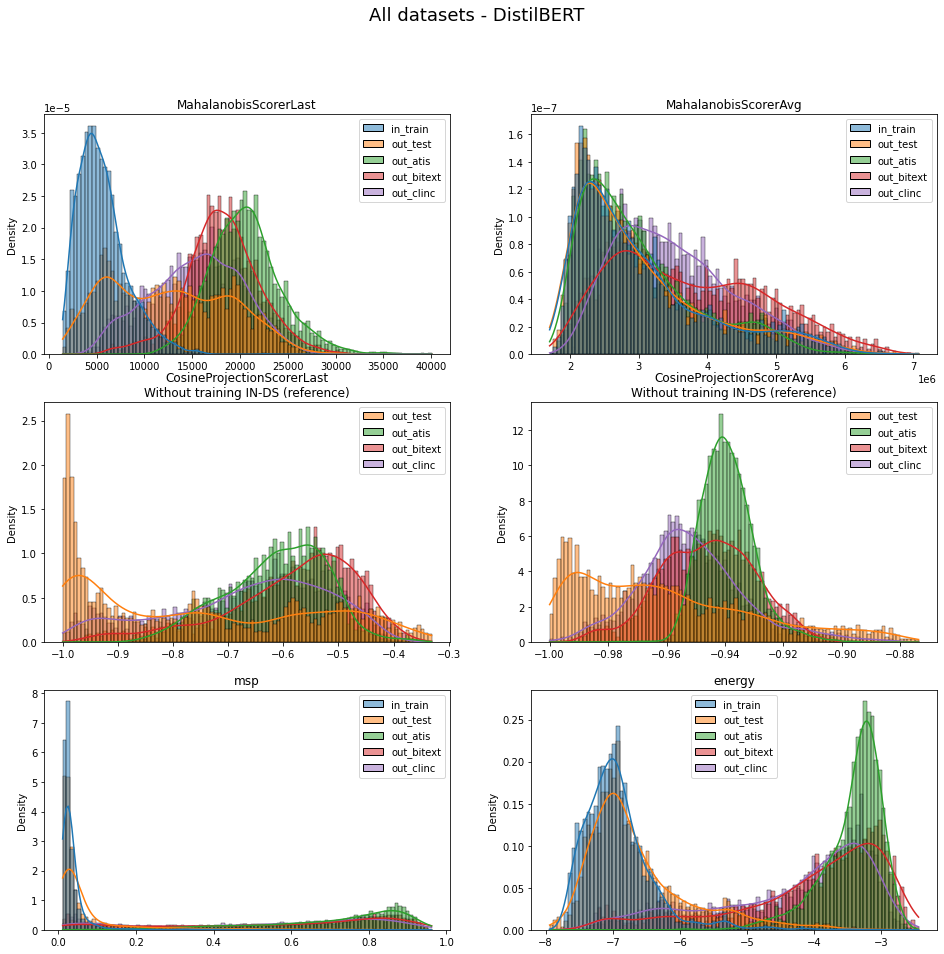

In [81]:
for model, scores in all_scores.items(): 

    fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(16, 15))
    fig.suptitle(f"All datasets - {model}", size=18)   

    for (scorer, records), ax in zip(scores.items(), axes.flatten()):
        plot_scorer_distrib(
            scorer, 
            records,
            ds_names=DS, 
            ax=ax, 
            density=True);   

#### `banking77`

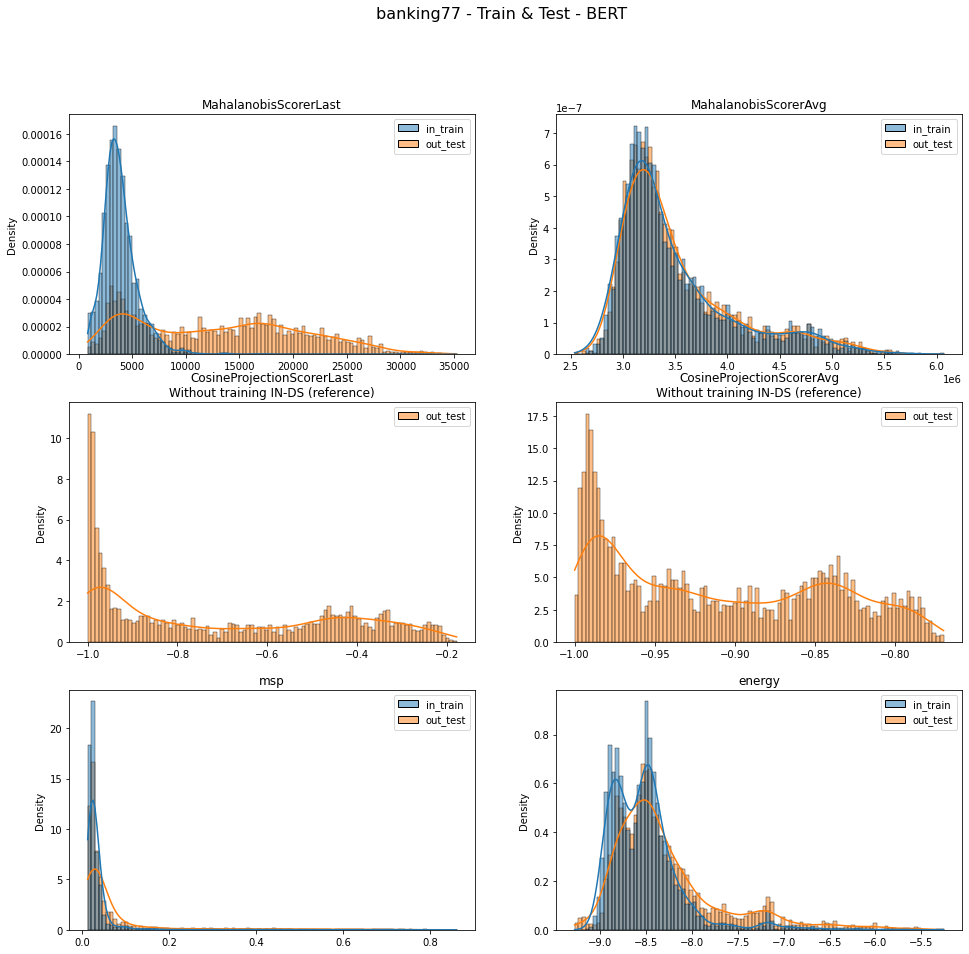

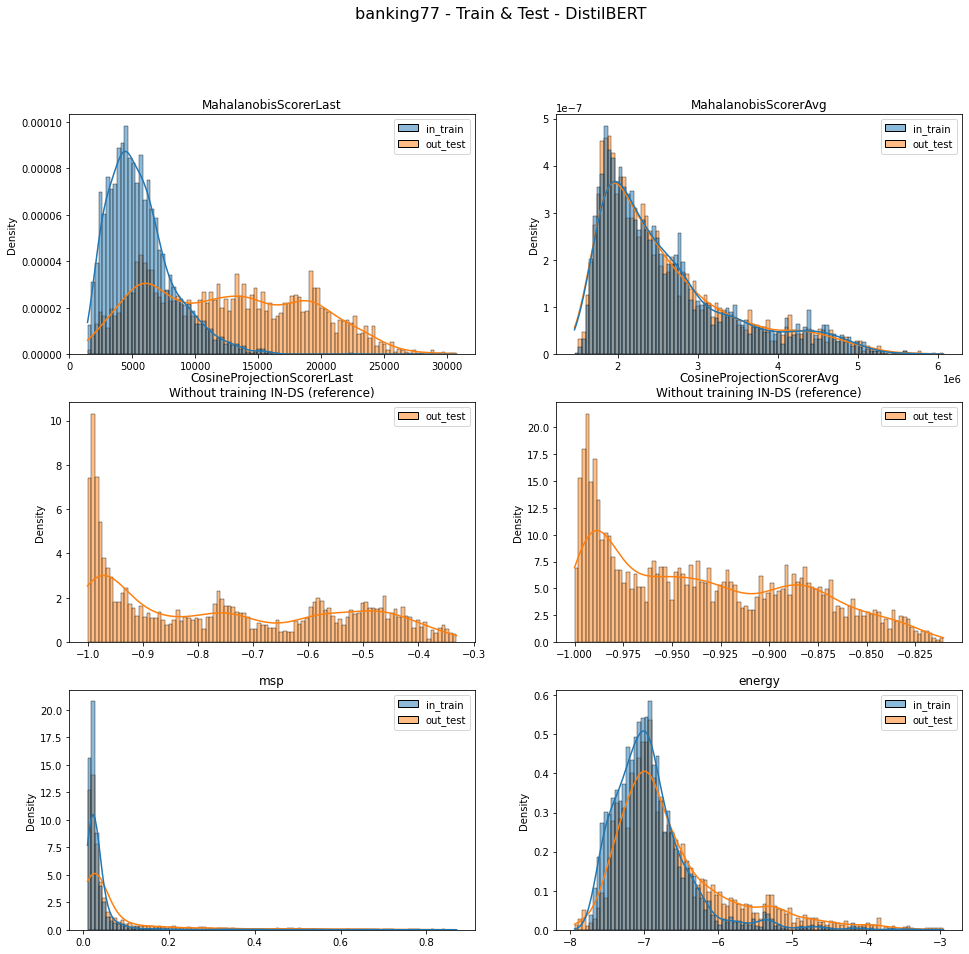

In [75]:
for model, scores in all_scores.items(): 

    fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(16, 15))
    fig.suptitle(f"banking77 - Train & Test - {model}", size=16)

    for (scorer, records_), ax in zip(scores.items(), axes.flatten()):
        plot_scorer_distrib(
            scorer, 
            records_,
            ds_names=["in_train", "out_test"], 
            ax=ax, 
            density=True); 

#### `banking77` & `ATIS`

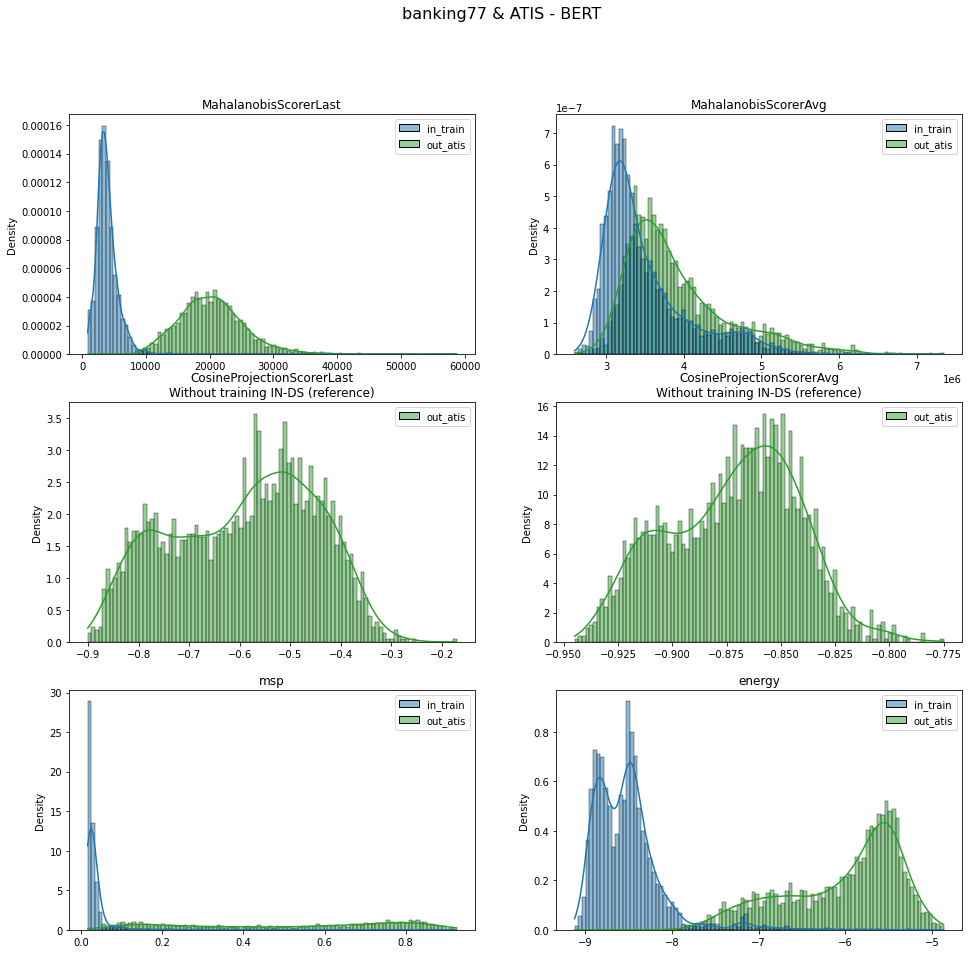

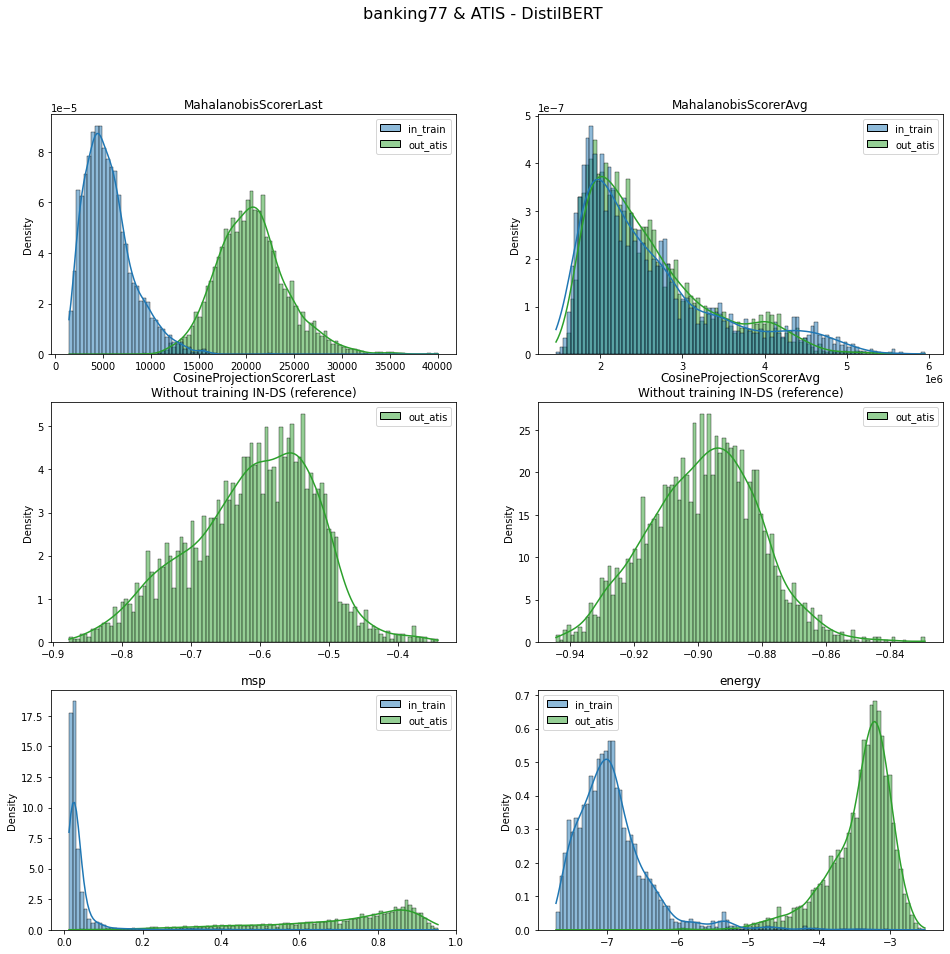

In [76]:
for model, scores in all_scores.items(): 
    
    fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(16, 15))
    fig.suptitle(f"banking77 & ATIS - {model}", size=16)

    for (scorer, records_), ax in zip(scores.items(), axes.flatten()):
        plot_scorer_distrib(
            scorer, 
            records_,
            ds_names=["in_train", "out_atis"], 
            ax=ax, 
            density=True); 

#### `banking77` & `Bitext`

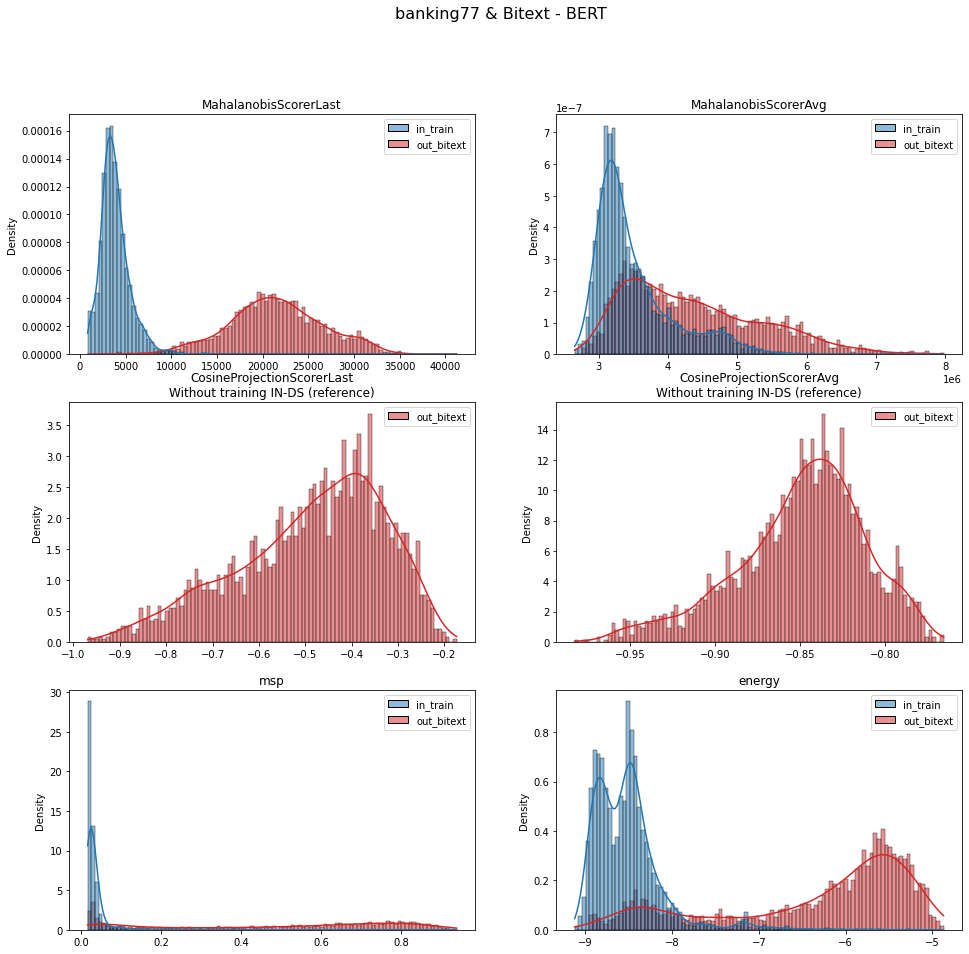

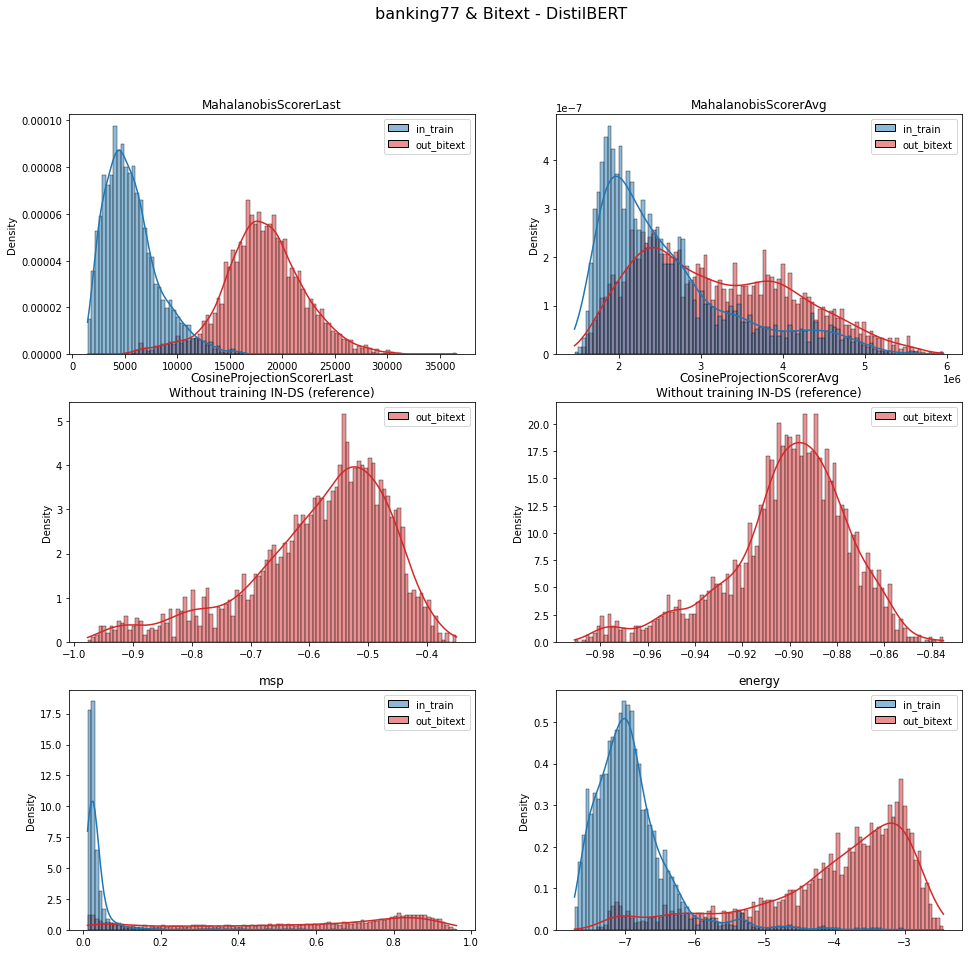

In [77]:
for model, scores in all_scores.items():   
    
    fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(16, 15))
    fig.suptitle(f"banking77 & Bitext - {model}", size=16)

    for (scorer, records_), ax in zip(scores.items(), axes.flatten()):
        plot_scorer_distrib(
            scorer, 
            records_,
            ds_names=["in_train", "out_bitext"], 
            ax=ax, 
            density=True); 

#### `banking77` & `CLINC150`

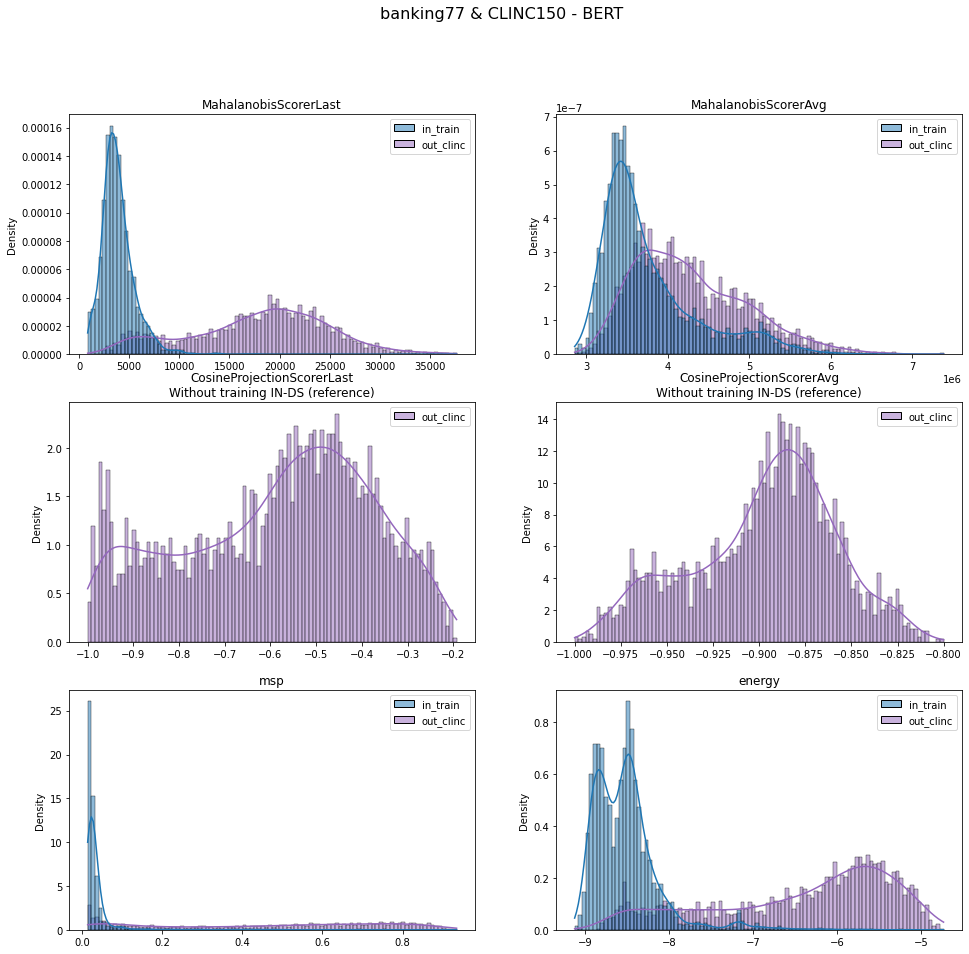

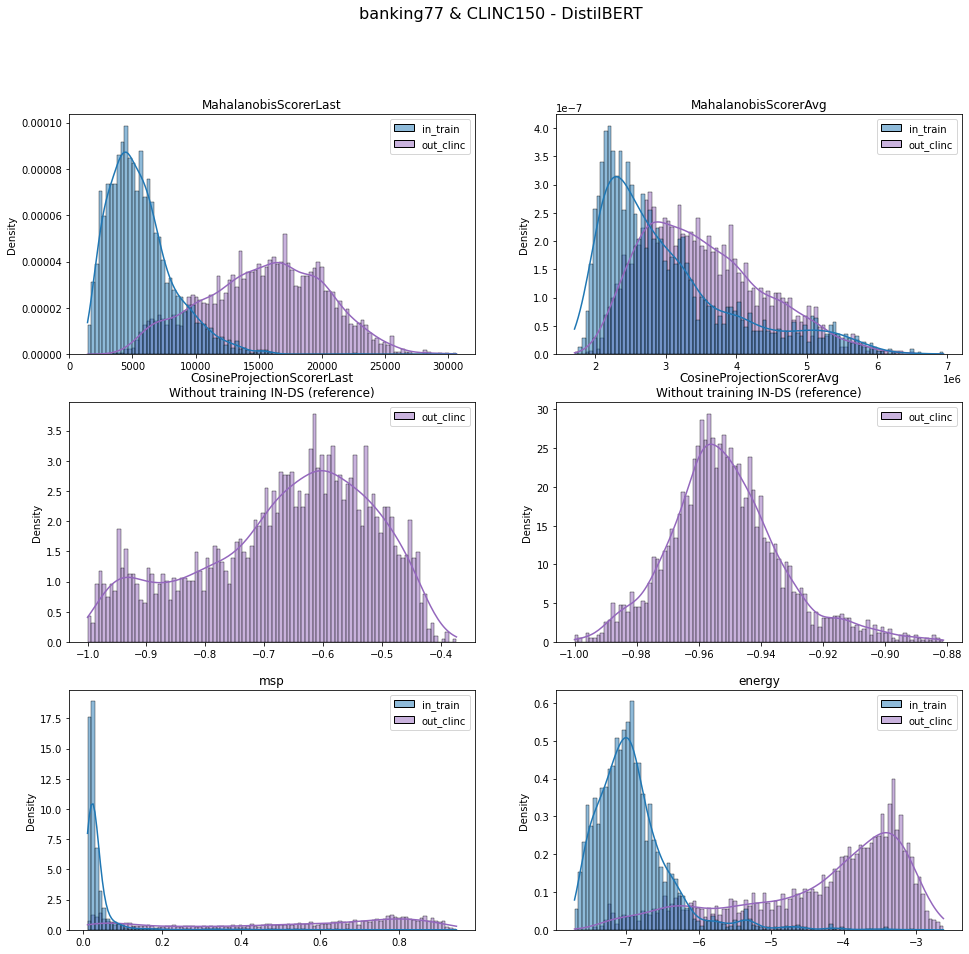

In [115]:
for model, scores in all_scores.items(): 

    fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(16, 15))
    fig.suptitle(f"banking77 & CLINC150 - {model}", size=16)

    for (scorer, records_), ax in zip(scores.items(), axes.flatten()):
        plot_scorer_distrib(
            scorer, 
            records_,
            ds_names=["in_train", "out_clinc"], 
            ax=ax, 
            density=True); 

### Metrics

In [22]:
# IN-DS samples: b77 train 
num_in_samples = config_args_b77["train_size"] 
print(f"{num_in_samples} intents labeled as in-distribution.")

labels_in = [config_args_b77["ood_label"] for _ in range(num_in_samples)]

# OUT-DS samples: b77 test, atis, bitext, clinc150
num_out_samples = config_args_out["test_size"] * 4
print(f"{num_out_samples} intents labeled as in-distribution.")

labels_out = [config_args_out["ood_label"] for _ in range(num_out_samples)]

labels = labels_in + labels_out

3000 intents labeled as in-distribution.

12000 intents labeled as in-distribution.

In [91]:
# get scores for each scoring function, for each encoder
scores = {

    model: {
        scorer: list(
            chain(*[
            val for val in scores_[scorer].values()
        ])
        )
        for scorer in SCORERS 
    }
    
    for model, scores_ in all_scores.items()
}

In [111]:
# compute (fpr, tpr) for different thresolds
roc = {
    model: {
        scorer: roc_curve(labels, scores_[scorer], pos_label=1)
        for scorer in SCORERS
    }
    for model, scores_ in scores.items()
}

# compute (precision, recall) for different thresolds
# pos_label is OOD=1
prc_out = {
    model: {
        scorer: precision_recall_curve(labels, scores_[scorer], pos_label=1)
        for scorer in SCORERS
    }
    for model, scores_ in scores.items()
}

# compute (precision, recall) for different thresolds
# pos_label is OOD=0
prc_in = {
    model: {
        scorer: precision_recall_curve(labels, [-s for s in scores_[scorer]], pos_label=0)
        for scorer in SCORERS
    }
    for model, scores_ in scores.items()
}

# area under the curve

# AUROC 
auroc = {
    model: {
        scorer: auc(fpr, tpr)
        for scorer, (fpr, tpr, _) in roc_.items()
    }
    for model, roc_ in roc.items()
}

# AUPR
aupr_in = {
    model: {
        scorer: auc(recall, precision)
        for scorer, (precision, recall, _) in prc_.items()
    }
    for model, prc_ in prc_in.items()
}

aupr_out = {
    model: {
        scorer: auc(recall, precision)
        for scorer, (precision, recall, _) in prc_.items()
    }
    for model, prc_ in prc_out.items()
}

print(f"{auroc=}")
print(f"{aupr_in=}")
print(f"{aupr_out=}")

auroc={'BERT': {'MahalanobisScorerLast': 0.95978175, 'MahalanobisScorerAvg': 
0.6906658055555555, 'CosineProjectionScorerLast': 0.9999030277777776, 
'CosineProjectionScorerAvg': 0.9998685972222222, 'msp': 0.8726339999999999, 'energy': 
0.8789059166666666}, 'DistilBERT': {'MahalanobisScorerLast': 0.9468210833333333, 
'MahalanobisScorerAvg': 0.5970712222222223, 'CosineProjectionScorerLast': 0.9998533611111111,
'CosineProjectionScorerAvg': 0.9998927361111111, 'msp': 0.8787836805555556, 'energy': 
0.8850046527777777}}

aupr_in={'BERT': {'MahalanobisScorerLast': 0.7830904045621211, 'MahalanobisScorerAvg': 
0.3421914207219309, 'CosineProjectionScorerLast': 0.9991376239001568, 
'CosineProjectionScorerAvg': 0.9991147740773882, 'msp': 0.5039928021206719, 'energy': 
0.5481229201277281}, 'DistilBERT': {'MahalanobisScorerLast': 0.7496085590179076, 
'MahalanobisScorerAvg': 0.264773579651294, 'CosineProjectionScorerLast': 0.9986189568525028, 
'CosineProjectionScorerAvg': 0.9994118958563158, 'msp': 0.5258999766145263, 'energy': 
0.5534537600173819}}

aupr_out={'BERT': {'MahalanobisScorerLast': 0.9908558142770326, 'MahalanobisScorerAvg': 
0.8915303092004335, 'CosineProjectionScorerLast': 0.9999793938913044, 
'CosineProjectionScorerAvg': 0.9999714832790335, 'msp': 0.9682638842313742, 'energy': 
0.9701021658836855}, 'DistilBERT': {'MahalanobisScorerLast': 0.9872805145581403, 
'MahalanobisScorerAvg': 0.8385729672736966, 'CosineProjectionScorerLast': 0.9999698391936556,
'CosineProjectionScorerAvg': 0.9999760760518763, 'msp': 0.9704031050806521, 'energy': 
0.9720895808115445}}

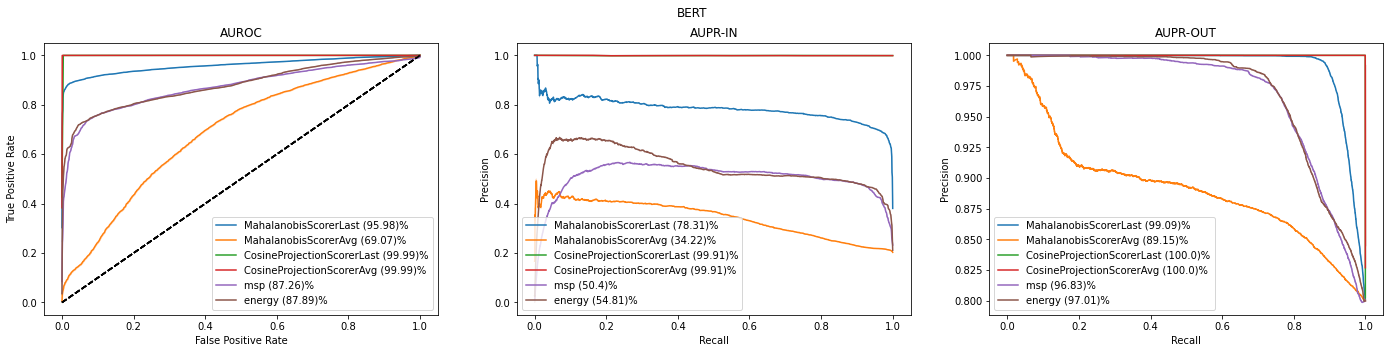

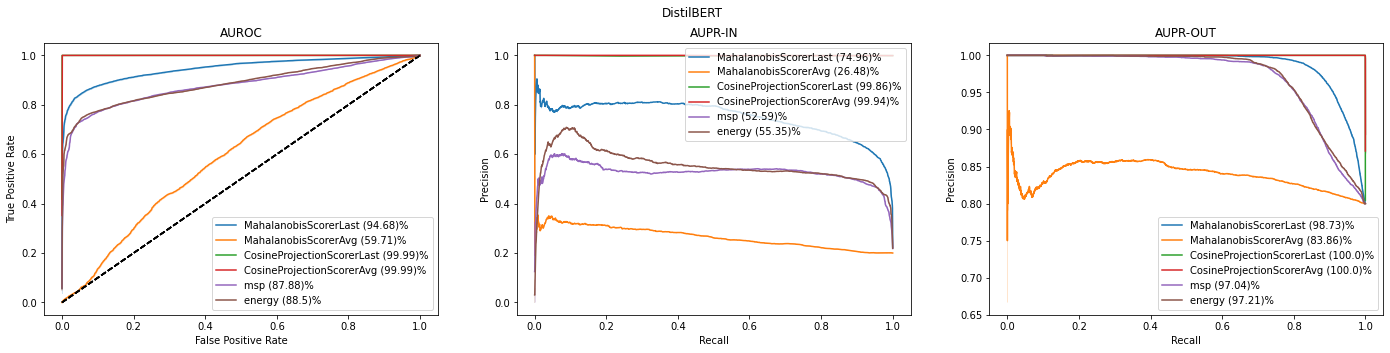

In [116]:
for model in ("BERT", "DistilBERT"): 

    fig, axes = plt.subplots(ncols=3, figsize=(24, 5))
    fig.suptitle(f"{model}")
    
    for scorer, (fpr, tpr, _) in roc[model].items(): 
        s = round(100*auroc[model][scorer], 2)
        label = f"{scorer} ({s})%"

        sns.lineplot(
            x=fpr, 
            y=tpr, 
            label=label, 
            color=COLORS_SCORERS[scorer], 
            ax=axes[0])
        
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", color="black", ax=axes[0]) 

    axes[0].set_title("AUROC")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")

    for scorer, (precision, recall, _) in prc_in[model].items(): 
        s = round(100*aupr_in[model][scorer], 2)
        label = f"{scorer} ({s})%"

        sns.lineplot(
            x=recall, 
            y=precision, 
            label=label, 
            color=COLORS_SCORERS[scorer], 
            ax=axes[1])

    axes[1].set_title("AUPR-IN")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")

    for scorer, (precision, recall, _) in prc_out[model].items(): 
        s = round(100*aupr_out[model][scorer], 2)
        label = f"{scorer} ({s})%"

        sns.lineplot(
            x=recall, 
            y=precision, 
            label=label, 
            color=COLORS_SCORERS[scorer], 
            ax=axes[2])

    axes[2].set_title("AUPR-OUT")
    axes[2].set_xlabel("Recall")
    axes[2].set_ylabel("Precision"); 

## Supervised learning

This section aims to learn a classifier which estimates the probability of a textual input to be *out-of-distribution*. The feature matrix is built from the scorers. 

### Preprocessing

In [8]:
# get BERT records

bert_records = {
    dataset: load_records(Model.BERT, dataset)
      for dataset in (
        "in_train", 
        "out_test", 
        "out_atis", 
        "out_bitext", 
        "out_clinc"
      )
}

In [13]:
# IN-DS samples: b77 train 
num_in_samples = len(bert_records["in_train"]["true_label"])
print(f"{num_in_samples} intents labeled as in-distribution.")

labels_in = [0 for _ in range(num_in_samples)]

# OUT-DS samples: b77 test, atis, bitext, clinc150
num_out_samples = sum(
    len(bert_records[ds]["true_label"])
    for ds in ("out_test", "out_atis", "out_bitext", "out_clinc")
)
print(f"{num_out_samples} intents labeled as in-distribution.")

labels_out = [1 for _ in range(num_out_samples)]

labels = np.array(labels_in + labels_out) 
labels.shape

3000 intents labeled as in-distribution.

12000 intents labeled as in-distribution.

(15000,)

In [55]:
def build_feature_matrix(records: Dict, scorers: List[str], layers: Optional[LayerSelection]) -> Tuple: 
    """Description. Build feature matrix from OOD scorers."""

    def _flatten(x: List) -> List: 
        return list(chain(*x))
    
    feature_names = [] 
    X = []

    for scorer in scorers:
        
        if scorer in ("MahalanobisScorer", "CosineProjectionScorer"): 
            for layer in layers.value:     
                X.append(
                    _flatten([get_scorer_per_layer(values, scorer, layer) for values in records.values()])
                )
                feature_names.append(f"{scorer}_layer_{layer}")

        elif scorer in SCORERS: 
            X.append(
                _flatten([values[scorer] for values in records.values()])
            )
            feature_names.append(scorer)
        
        else: 
            raise ValueError(f"scorers must be in {['MahalanobisScorer', 'CosineProjectionScorer'] + SCORERS})")

    X = np.array(X).T 

    return X, feature_names

In [56]:
X, feature_names = build_feature_matrix(
    bert_records, 
    scorers=["msp", "energy", "MahalanobisScorer"], 
    layers=LayerSelection.ENCODER_BERT
)
 
y = np.array(labels)  

print(f"Shape of feature matrix: {X.shape}")
print(f"Shape of target vector: {y.shape}")

Shape of feature matrix: (15000, 14)

Shape of target vector: (15000,)

In [57]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y)

### `RandomForestClassifier`

#### Outputs-based scorers

In [58]:
# only msp & energy 

rf = RandomForestClassifier()
rf.fit(X_tr[:, :2], y_tr)

RandomForestClassifier()

In [59]:
print(classification_report(y_te, 
                            y_pred=rf.predict(X_te[:, :2]), 
                            target_names=["IN", "OOD"])) 

precision    recall  f1-score   support

          IN       0.59      0.53      0.56       745
         OOD       0.89      0.91      0.90      3005

    accuracy                           0.83      3750
   macro avg       0.74      0.72      0.73      3750
weighted avg       0.83      0.83      0.83      3750

#### Add per layer `MahalanobisScorer` 

In [60]:
rf = RandomForestClassifier()
rf.fit(X_tr, y_tr)

RandomForestClassifier()

In [61]:
print(classification_report(y_te, 
                            y_pred=rf.predict(X_te), 
                            target_names=["IN", "OOD"])) 

precision    recall  f1-score   support

          IN       0.79      0.94      0.86       745
         OOD       0.98      0.94      0.96      3005

    accuracy                           0.94      3750
   macro avg       0.89      0.94      0.91      3750
weighted avg       0.95      0.94      0.94      3750

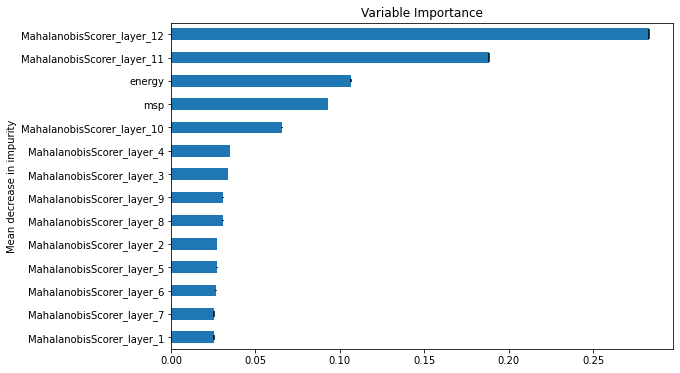

In [72]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(9, 6))

forest_importances\
    .sort_values()\
    .plot.barh(yerr=std, align="center", ax=ax)

ax.set_title("Variable Importance")
ax.set_ylabel("Mean decrease in impurity"); 

We fit another `RandomForestClassifier` keeping only `msp`, `energy`, `MahalanobisScorer_layer_10`, `MahalanobisScorer_layer_11` and `MahalanobisScorer_layer_12` as features. 

In [76]:
to_keep = (
    "msp",
    "energy",
    "MahalanobisScorer_layer_9",
    "MahalanobisScorer_layer_10",
    "MahalanobisScorer_layer_11",
    "MahalanobisScorer_layer_12", 
)

idxs = [
    ix 
    for ix, feature in enumerate(feature_names)
    if feature in to_keep
]

[0, 1, 10, 11, 12, 13]

In [77]:
rf = RandomForestClassifier()
rf.fit(X_tr[:, idxs], y_tr)

RandomForestClassifier()

In [78]:
print(classification_report(y_te, 
                            y_pred=rf.predict(X_te[:, idxs]), 
                            target_names=["IN", "OOD"])) 

precision    recall  f1-score   support

          IN       0.80      0.93      0.86       745
         OOD       0.98      0.94      0.96      3005

    accuracy                           0.94      3750
   macro avg       0.89      0.93      0.91      3750
weighted avg       0.94      0.94      0.94      3750

In [79]:
balanced_accuracy_score(y_te, rf.predict(X_te[:, idxs]))

0.9348122257088298